# Study of the model

The model is currently overfitting. Let's load it and study how many parameters it has and other things.

In [1]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs
from graph2mat4abn.tools.scripts_utils import get_model_dataset
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.

In [2]:
# load config file:
model_dir = Path("results/h_crystalls_8")
config = load_config(model_dir / "config.yaml")


In [3]:
# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)
paths = train_paths + val_paths
basis = get_basis_from_structures_paths(paths, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
# === Enviroment descriptor initialization ===
env_config = config["environment_representation"]

num_interactions = env_config["num_interactions"]
hidden_irreps = o3.Irreps(env_config["hidden_irreps"])

# ! This operation is somehow time-consuming:
mace_descriptor = MACE(
    r_max=env_config["r_max"],
    num_bessel=env_config["num_bessel"],
    num_polynomial_cutoff=env_config["num_polynomial_cutoff"],
    max_ell=env_config["max_ell"],
    interaction_cls=RealAgnosticResidualInteractionBlock,
    interaction_cls_first=RealAgnosticResidualInteractionBlock,
    num_interactions=num_interactions,
    num_elements=env_config["num_elements"],
    hidden_irreps=hidden_irreps,
    MLP_irreps=o3.Irreps(env_config["MLP_irreps"]),
    atomic_energies=torch.tensor(env_config["atomic_energies"]),
    avg_num_neighbors=env_config["avg_num_neighbors"],
    atomic_numbers=env_config["atomic_numbers"],
    correlation=env_config["correlation"],
    gate=get_object_from_module(env_config["gate"], "torch.nn.functional"),
)



# === Model initialization ===
model_config = config["model"]

# === Glue between MACE and E3nnGraph2Mat init ===
model = MatrixMACE(
    mace = mace_descriptor,
    readout_per_interaction=model_config.get("readout_per_interaction", False),
    graph2mat_cls = E3nnGraph2Mat,
    
    # Readout-specific arguments
    unique_basis = table,
    symmetric = True,

    # Preprocessing
    preprocessing_edges = get_object_from_module(
        model_config["preprocessing_edges"], 
        'graph2mat.bindings.e3nn.modules'
    ),
    preprocessing_edges_kwargs = get_kwargs(model_config["preprocessing_edges"], config),

    preprocessing_nodes = get_object_from_module(
        model_config["preprocessing_nodes"], 
        'graph2mat.bindings.e3nn.modules'
    ),
    preprocessing_nodes_kwargs = get_kwargs(model_config["preprocessing_nodes"], config),

    # Operations
    node_operation = get_object_from_module(
        model_config["node_operation"], 
        'graph2mat.bindings.e3nn.modules'
    ),
    node_operation_kwargs = get_kwargs(model_config["node_operation"], config),

    edge_operation = get_object_from_module(
        model_config["edge_operation"], 
        'graph2mat.bindings.e3nn.modules'
    ),
    edge_operation_kwargs = get_kwargs(model_config["edge_operation"], config),
)

Basis computation.
Number of structures to look on: 582
Looking for unique atoms in each structure...


1it [00:00, 56.82it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [5, 7]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(atomic_energies, dtype=torch.get_default_dtype()),


Great! We already have our model initialized. Let's study it.

In [4]:
print(model)

MatrixMACE(
  (mace): MACE(
    (node_embedding): LinearNodeEmbeddingBlock(
      (linear): Linear(2x0e -> 10x0e | 20 weights)
    )
    (radial_embedding): RadialEmbeddingBlock(
      (bessel_fn): BesselBasis(r_max=10.0, num_basis=15, trainable=False)
      (cutoff_fn): PolynomialCutoff(p=8, r_max=10.0)
    )
    (spherical_harmonics): SphericalHarmonics()
    (atomic_energies_fn): AtomicEnergiesBlock(energies=[[0.0000, 0.0000]])
    (interactions): ModuleList(
      (0): RealAgnosticResidualInteractionBlock(
        (linear_up): Linear(10x0e -> 10x0e | 100 weights)
        (conv_tp): TensorProduct(10x0e x 1x0e+1x1o+1x2e+1x3o -> 10x0e+10x1o+10x2e+10x3o | 40 paths | 40 weights)
        (conv_tp_weights): FullyConnectedNet[15, 64, 64, 64, 40]
        (linear): Linear(10x0e+10x1o+10x2e+10x3o -> 10x0e+10x1o+10x2e+10x3o | 400 weights)
        (skip_tp): FullyConnectedTensorProduct(10x0e x 2x0e -> 10x0e+10x1o+10x2e+10x3o | 200 paths | 200 weights)
        (reshape): reshape_irreps()
      )

Our model consists in two parts: 

1. The MACE atomic enviroment descriptor (with learnable layers)

2. The Graph2Mat matrix readouts.

Let's study each model separately.

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------------------------------------------+------------+
|                                  Modules                                  | Parameters |
+---------------------------------------------------------------------------+------------+
|                     mace.node_embedding.linear.weight                     |     20     |
|                    mace.interactions.0.linear_up.weight                   |    100     |
|             mace.interactions.0.conv_tp_weights.layer0.weight             |    960     |
|             mace.interactions.0.conv_tp_weights.layer1.weight             |    4096    |
|             mace.interactions.0.conv_tp_weights.layer2.weight             |    4096    |
|             mace.interactions.0.conv_tp_weights.layer3.weight             |    2560    |
|                     mace.interactions.0.linear.weight                     |    400     |
|                     mace.interactions.0.skip_tp.weight                    |    200     |

311098

In [6]:
count_parameters(mace_descriptor)

+--------------------------------------------------------------+------------+
|                           Modules                            | Parameters |
+--------------------------------------------------------------+------------+
|                 node_embedding.linear.weight                 |     20     |
|               interactions.0.linear_up.weight                |    100     |
|         interactions.0.conv_tp_weights.layer0.weight         |    960     |
|         interactions.0.conv_tp_weights.layer1.weight         |    4096    |
|         interactions.0.conv_tp_weights.layer2.weight         |    4096    |
|         interactions.0.conv_tp_weights.layer3.weight         |    2560    |
|                 interactions.0.linear.weight                 |    400     |
|                interactions.0.skip_tp.weight                 |    200     |
|               interactions.1.linear_up.weight                |    400     |
|         interactions.1.conv_tp_weights.layer0.weight         |

45114

So there is a total of 311098 parameters, which 45114 are from Mace and the rest (85%) are from the matrix readouts.

As the readouts are basically MACE layers, we need first to understand what is MACE.

# What is the shape of the MACE descriptor?

In [86]:
# Let's test the output of the mace model
from graph2mat4abn.tools.scripts_utils import generate_g2m_dataset_from_paths
from torch_geometric.data import DataLoader
train_dataset, val_dataset, processor = generate_g2m_dataset_from_paths(config, basis, table, train_paths[:10], val_paths[:2], device='cpu', verbose=True)
loader = DataLoader(train_dataset, batch_size=1)
data = next(iter(loader))

mace_output = mace_descriptor(data)
print(mace_output["node_feats"])

Generating dataset...
Generating split 0...


10it [00:00, 27.91it/s]


Generating split 1...


2it [00:00, 24.58it/s]


Keeping all the dataset in memory.


/home/alapena/miniconda3/envs/g2m_upd/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



tensor([[ 0.1141,  0.0440,  0.0510,  ..., -0.1767, -0.0942, -0.0275],
        [-0.3939, -0.7888, -0.1775,  ..., -0.1010, -0.3878, -0.0420],
        [ 0.1138,  0.0436,  0.0512,  ..., -0.1772, -0.0953, -0.0278],
        ...,
        [ 0.1133,  0.0427,  0.0513,  ..., -0.1769, -0.0956, -0.0279],
        [-0.3940, -0.7887, -0.1775,  ..., -0.1009, -0.3878, -0.0420],
        [ 0.1139,  0.0425,  0.0509,  ..., -0.1775, -0.0958, -0.0274]],
       grad_fn=<CatBackward0>)


In [16]:
print(mace_output["node_feats"].shape)
print(mace_output["node_feats"].max())
print(mace_output["node_feats"].min())

torch.Size([8, 170])
tensor(0.5288, grad_fn=<MaxBackward1>)
tensor(-0.7914, grad_fn=<MinBackward1>)


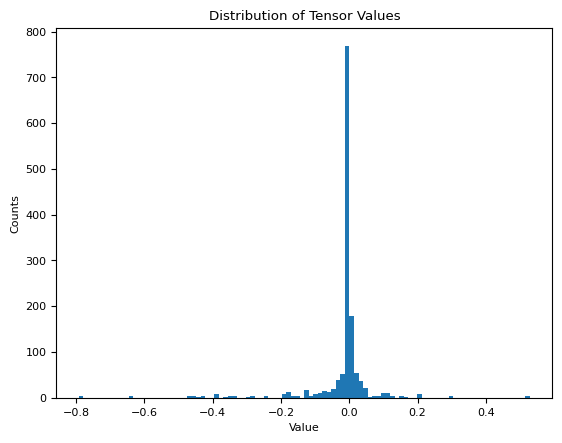

In [38]:
import matplotlib.pyplot as plt
flatdata = mace_output["node_feats"].flatten()
# Convert to numpy for plotting
x_np = flatdata.detach().numpy()

def plot_histogram(x_np):
    plt.hist(x_np, bins=100)
    plt.xlabel("Value")
    plt.ylabel("Counts")
    plt.title("Distribution of Tensor Values")
    plt.show()

plot_histogram(x_np)
None

Great news! The common values of the descriptor are in the range of (-1,1). This means that I do not need to normalize anything (or at least I don't expect it to be important). Although most of the valeus are around zero.

# And what is the shape of the whole model?

In [30]:
y = model(data)

In [105]:
print(data.point_labels.shape)
print(data.edge_labels.shape)
data

torch.Size([1352])
torch.Size([76050])


TorchBasisMatrixDataBatch(
  metadata={
    device=[1],
    atom_types=[8],
    path=[1],
    data_processor=[1],
  },
  edge_index=[2, 900],
  num_nodes=8,
  neigh_isc=[900],
  n_edges=[1],
  positions=[8, 3],
  shifts=[900, 3],
  cell=[3, 3],
  nsc=[1, 3],
  node_attrs=[8, 2],
  point_labels=[1352],
  edge_labels=[76050],
  point_types=[8],
  edge_types=[900],
  batch=[8],
  ptr=[2]
)

tensor([-1.7957e-04,  5.0642e-06, -7.2421e-06,  ..., -8.3151e-05,
         5.6578e-07, -3.4271e-04], grad_fn=<IndexBackward0>)
tensor([-8.8787e+00, -7.2973e+00, -1.3642e-01,  ..., -1.0455e+00,
        -5.5454e-03,  2.5290e+00])


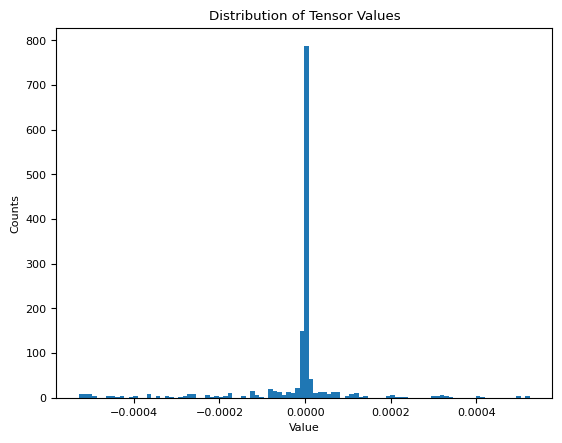

In [39]:
print(y["node_labels"])
print(data.point_labels)
plot_histogram(y["node_labels"].flatten().detach().numpy())

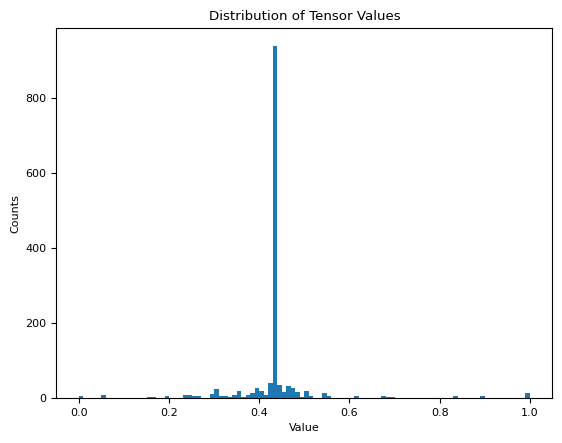

In [44]:
# Let's try to normalize
x = data.point_labels   
x_min = x.min()
x_max = x.max()
x_norm = (x - x_min) / (x_max - x_min + 1e-8)
plot_histogram(x_norm.flatten().detach().numpy())

I don't like it. Now there are even more zeroes and it is less homogeneous

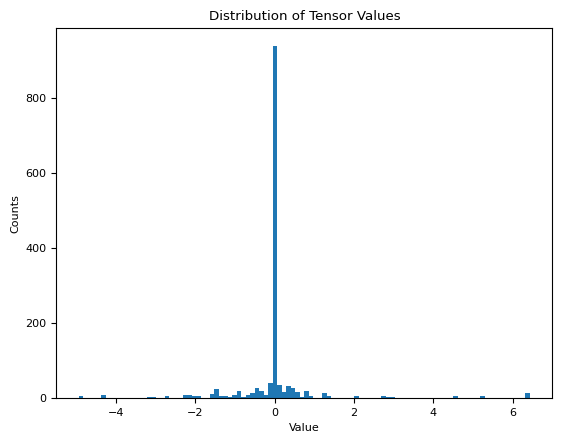

In [45]:
mean = x.mean()
std = x.std()

# Avoid division by zero
x_standardized = (x - mean) / (std + 1e-8)
plot_histogram(x_standardized.flatten().detach().numpy())

More or less the same result.

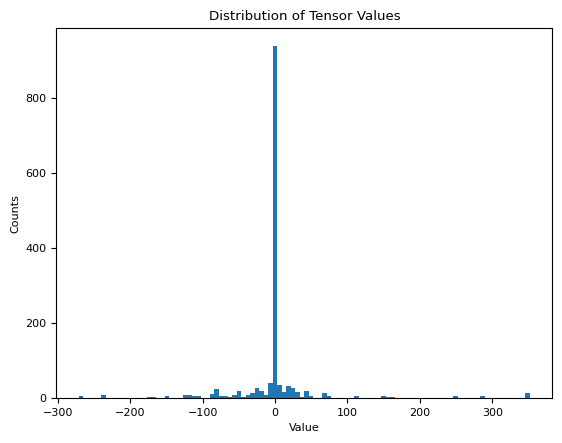

In [46]:
x = data.point_labels

median = x.median()
q1 = x.kthvalue(int(0.25 * x.numel()))[0]
q3 = x.kthvalue(int(0.75 * x.numel()))[0]
iqr = q3 - q1 + 1e-8  # avoid zero

x_robust = (x - median) / iqr
plot_histogram(x_robust.flatten().detach().numpy())

In [52]:
# Mean
print(x.abs().mean())
x.shape

tensor(1.1621)


torch.Size([1352])

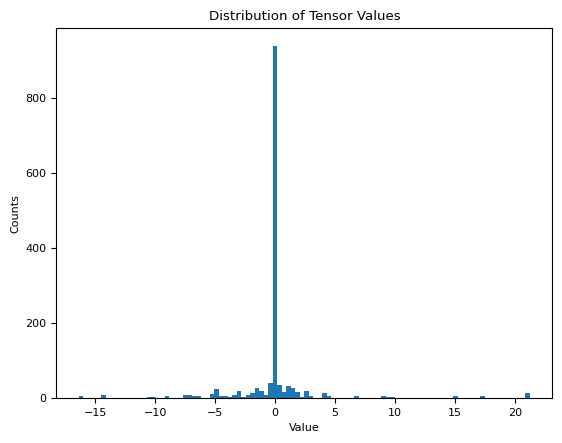

In [114]:
x = data.point_labels
nonzero_mask = x > 0.1
mean_nonzero = x[nonzero_mask].mean()

x_scaled = x / (mean_nonzero + 1e-8)
plot_histogram(x.flatten().detach().numpy())

In [118]:
data.edge_labels.abs()

tensor([2.1939e-09, 0.0000e+00, 5.4589e-10,  ..., 3.6036e-02, 5.7013e-02,
        1.2233e-02])